In [1]:
%pip install torch --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install "trl>=0.20.0" "peft>=0.17.0" "transformers>=4.55.0" trackio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.1/846.1 kB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 18.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 37.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 kB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
from datasets import load_dataset

dataset = load_dataset("HuggingFaceH4/Multilingual-Thinking", split="train")
dataset

Dataset({
    features: ['reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages'],
    num_rows: 1000
})

In [3]:
dataset[0]['messages']

[{'content': 'reasoning language: French\n\nYou are an AI chatbot with a lively and energetic personality.',
  'role': 'system',
  'thinking': None},
 {'content': 'Can you show me the latest trends on Twitter right now?',
  'role': 'user',
  'thinking': None},
 {'content': 'Hey there!  While I can\'t check Twitter (X) in real-time or access live data, I can share some tips to help you spot the latest trends:\n\n1. **Open the "Trending" tab** on the Twitter app or website – it updates constantly!  \n2. **Search for hashtags** like #Trending or #Viral to see what’s blowing up.  \n3. **Follow accounts** that curate trends (e.g., @TrendingNow, @ViralThreads).  \n4. **Check regional trends** – they often differ by location!  \n\nRemember, trends are *super fast-moving* and often tied to pop culture, memes, or breaking news. For example, recent trends have included viral challenges (like the "Distracted Boyfriend" meme revival), celebrity drama, or unexpected events (hello, weather disasters

In [4]:
from transformers import AutoTokenizer, get_scheduler
from torch.optim import AdamW
from datasets import load_dataset
from peft import LoraConfig

In [5]:
# Load tokenizer & dataset
tokenizer = AutoTokenizer.from_pretrained("openai/gpt-oss-20b", use_fast=True)
dataset = load_dataset("HuggingFaceH4/Multilingual-Thinking", split="train")

In [6]:
dataset[0]

{'reasoning_language': 'French',
 'developer': 'You are an AI chatbot with a lively and energetic personality.',
 'user': 'Can you show me the latest trends on Twitter right now?',
 'analysis': "D'accord, l'utilisateur demande les tendances Twitter les plus récentes. Tout d'abord, je dois vérifier si j'ai accès à des données en temps réel. Étant donné que je ne peux pas naviguer sur Internet ou accéder directement à l'API de Twitter, je ne peux pas fournir des tendances en direct. Cependant, je peux donner quelques conseils généraux sur la façon de les trouver.\n\nJe devrais préciser que les tendances Twitter évoluent rapidement et sont spécifiques à chaque région. Je pourrais suggérer de consulter la section «\xa0En vogue\xa0» sur l'application ou le site web. Aussi, l'utilisation de hashtags et le suivi d'utilisateurs pertinents pourraient être utiles. Il est important de souligner que les tendances varient selon la région et l'heure de la journée. Je devrais garder un ton amical et 

In [7]:
# dataset.set_format(type="torch", columns=["messages"])

In [8]:
def tokenize(batch):
    # batch['messages'] is a list of lists of dicts
    # Apply chat template -> gives list of strings (one string per example)
    texts = tokenizer.apply_chat_template(
        batch["messages"],
        tokenize=False,  # return strings first
        add_generation_prompt=True
    )
    
    # Now tokenize properly with padding/truncation
    enc = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_tensors='pt'  # keep as lists for datasets
    )
    return {
        "input_ids": enc["input_ids"],            # list of lists
        "attention_mask": enc["attention_mask"]   # list of lists of 0/1
    }

dataset = dataset.map(tokenize, batched=True, remove_columns=["messages"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])


In [9]:
# Config for LoRA
lora_config = LoraConfig(
    r=16, lora_alpha=32, target_modules=["q_proj","v_proj"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)

In [10]:
import torch
import torch.nn as nn
from peft import LoraModel
from transformers import AutoModelForCausalLM, AutoTokenizer

class GatedLoRAModel(nn.Module):
    def __init__(self, base_model_name, lora_config):
        super().__init__()
        # Base frozen GPT OSS model
        self.base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
        self.base_model.requires_grad_(False)

        # LoRA adapted GPT OSS model (trainable)
        self.lora_model = LoraModel(self.base_model, lora_config, adapter_name="default")

        # Gating network: learns how much weight to give LoRA vs base
        hidden_size = self.base_model.config.hidden_size
        self.gate = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()  # outputs value in [0,1]
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Hidden states from base (frozen)
        with torch.no_grad():
            base_out = self.base_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = base_out.hidden_states  # now this works
        base_logits = base_out.logits
        hidden = base_out.hidden_states[-1].float()  # final hidden states

        # LoRA adapted output
        lora_out = self.lora_model(input_ids, attention_mask=attention_mask)
        lora_logits = lora_out.logits

        # Gate value per token
        gate_vals = self.gate(hidden).squeeze(-1).unsqueeze(-1)  # [batch, seq, 1]

        # Weighted combination of logits
        combined_logits = (1 - gate_vals) * base_logits + gate_vals * lora_logits

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # shift for causal LM
            loss = loss_fct(
                combined_logits[:, :-1, :].reshape(-1, combined_logits.size(-1)),
                labels[:, 1:].reshape(-1)
            )
        return {"loss": loss, "logits": combined_logits}


In [12]:
# Build gated model
model = GatedLoRAModel("openai/gpt-oss-20b", lora_config).cuda()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# Optimizer (only trainable params: LoRA + gate)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)

In [14]:
# Scheduler
num_training_steps = 1000
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=50, num_training_steps=num_training_steps)

In [15]:
import torch
from torch.utils.data import DataLoader

# Simple DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

model.train()
model.cuda()  # move model to GPU
losses = []

for step, batch in enumerate(loader):
    input_ids = batch["input_ids"].cuda()
    attention_mask = batch["attention_mask"].cuda()
    labels = input_ids.clone()  # causal LM

    out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = out["loss"]
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if step % 10 == 0:
        print(f"Step {step} | Loss: {loss.item():.4f}")


Step 0 | Loss: 9.2621
Step 10 | Loss: 3.9471
Step 20 | Loss: 2.3824
Step 30 | Loss: 5.5865
Step 40 | Loss: 1.9485
Step 50 | Loss: 3.2840
Step 60 | Loss: 2.5509
Step 70 | Loss: 3.7286
Step 80 | Loss: 2.9542
Step 90 | Loss: 3.9879
Step 100 | Loss: 3.3392
Step 110 | Loss: 2.1547
Step 120 | Loss: 2.1189
Step 130 | Loss: 3.1816
Step 140 | Loss: 1.8744
Step 150 | Loss: 3.1237
Step 160 | Loss: 1.8364
Step 170 | Loss: 2.4832
Step 180 | Loss: 3.6089
Step 190 | Loss: 2.9618
Step 200 | Loss: 3.8530
Step 210 | Loss: 1.6093
Step 220 | Loss: 4.3141
Step 230 | Loss: 4.5389
Step 240 | Loss: 5.5645
Step 250 | Loss: 3.1977
Step 260 | Loss: 1.4094
Step 270 | Loss: 1.8813
Step 280 | Loss: 4.6228
Step 290 | Loss: 2.7121
Step 300 | Loss: 4.0374
Step 310 | Loss: 3.7217
Step 320 | Loss: 2.4888
Step 330 | Loss: 4.3030
Step 340 | Loss: 3.4769
Step 350 | Loss: 2.6329
Step 360 | Loss: 3.9657
Step 370 | Loss: 5.7714
Step 380 | Loss: 3.2513
Step 390 | Loss: 2.8121
Step 400 | Loss: 2.5093
Step 410 | Loss: 2.1168
Ste

In [21]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [18]:
import matplotlib.pyplot as plt

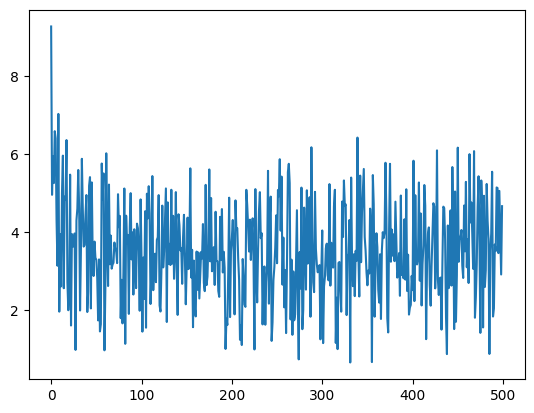

In [19]:
plt.plot(losses)

In [28]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
for step, batch in enumerate(loader):
    input_ids = batch["input_ids"].cuda()
    attention_mask = batch["attention_mask"].cuda()

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    print(out['logits'])
    o1 = torch.argmax(out['logits'], dim=2, keepdim=False)
    print(tokenizer.batch_decode(o1))
    break

tensor([[[ 5.6338e+00,  9.0575e+00,  8.8649e+00,  ...,  1.3262e-01,
          -1.0871e-01,  7.7385e-02],
         [ 4.8750e+00,  6.7500e+00,  5.8438e+00,  ..., -4.8218e-03,
          -8.6914e-02,  5.2246e-02],
         [ 1.5563e+01,  1.5563e+01,  1.6375e+01,  ...,  4.2725e-02,
          -1.1328e-01,  4.3701e-02],
         ...,
         [ 8.1875e+00,  8.3750e+00,  9.6250e+00,  ...,  2.4292e-02,
          -2.7008e-03,  1.8799e-02],
         [ 8.1250e+00,  8.2500e+00,  9.7500e+00,  ...,  2.1362e-02,
          -2.8992e-03,  2.1606e-02],
         [ 8.2500e+00,  8.2500e+00,  9.8750e+00,  ...,  1.8921e-02,
          -1.8501e-04,  2.0996e-02]]], device='cuda:0', grad_fn=<AddBackward0>)
['system<|message|>You are ChatGPT, a large language model trained by OpenAI.\nKnowledge cutoff: 2024-06\nCurrent date: 2025-09-08\n\nReasoning: medium\n\n# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions\n\nreasoning lang